# 1. Import Modules

In [274]:
# Set seed for reproducibility
import random; random.seed(53)
import pandas as pd
# Import all we need from sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
import csv
import re
import tweepy
from datetime import datetime
import nltk
import requests
import lxml.html as lh
from ipywidgets import *

# 2. Access to Twitter API

Authenticating developer credentials to connect to Twitter API

In [275]:
import tweepy
_consumer_key = 'HkXoe8k0GBn5gz5BCUC9fzorr'
_consumer_secret = 'rjuM4wX7lX8iWSxD478Ecjk8GE51OQROssp0MU66qNX8VQpKTG'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAKOkiQEAAAAA9r54bm8%2BSmGSHHq8iR1mTIqWK9g%3D8DXLPKRKah7E9W5GmBI7inZ41UpsCRoFwQhfEl1yxwEyzFR1lY'
auth = tweepy.OAuthHandler(_consumer_key, _consumer_secret)
api = tweepy.API(auth)


# 3. Collecting Data from Twitter

Collecting Timeline data of users:

The timeline of a certain user are the past tweets that he or she has published or retweeted.
This method can be used to return only the last 3200 tweets.

In [276]:
def get_tweets(university_name):
  alltweets = []
  new_tweets = api.user_timeline(screen_name = university_name, count = 200)
  alltweets.extend(new_tweets)

  oldest = alltweets[-1].id - 1
  while len(new_tweets) > 0:
    print ("getting tweets before %s" % (oldest))
    new_tweets = api.user_timeline(screen_name = university_name, count = 200, max_id = oldest)
    # save most recent tweets
    alltweets.extend(new_tweets)
    # update the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    print ("...%s tweets downloaded from %s so far" % (len(alltweets), university_name))

  print("Downloading tweets for %s has been finished..." %university_name)
  for tweet in alltweets:
    if "media" in tweet.entities:
      tweet.entities['media'] = 1
    else:
      tweet.entities['media'] = 0
  outtweets = [[university_name,tweet.id,tweet.text.encode("utf-8"),tweet.created_at,tweet.retweet_count,tweet.favorite_count,tweet.lang,tweet.entities['media']] for tweet in alltweets]
      
  # write the csv	
  with open('%s_tweets.csv' % university_name, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["author","id","text","date","retweet_count","favorite_count","language","media"])
    writer.writerows(outtweets)
  pass

**Specify the University Names Here:**

In [277]:
screen_name_uni_1 = "UniofOxford"
get_tweets(screen_name_uni_1)

screen_name_uni_2 = "Cambridge_Uni"
get_tweets(screen_name_uni_2)

getting tweets before 1582372431620370431
...400 tweets downloaded from UniofOxford so far
getting tweets before 1573253843407749120
...600 tweets downloaded from UniofOxford so far
getting tweets before 1560198836479467520
...800 tweets downloaded from UniofOxford so far
getting tweets before 1550850975249874944
...1000 tweets downloaded from UniofOxford so far
getting tweets before 1542440371325648901
...1200 tweets downloaded from UniofOxford so far
getting tweets before 1530549961397616639
...1400 tweets downloaded from UniofOxford so far
getting tweets before 1519724382351933440
...1600 tweets downloaded from UniofOxford so far
getting tweets before 1509090940295778305
...1800 tweets downloaded from UniofOxford so far
getting tweets before 1496866013492690948
...2000 tweets downloaded from UniofOxford so far
getting tweets before 1487563981594238978
...2200 tweets downloaded from UniofOxford so far
getting tweets before 1479392590910967814
...2400 tweets downloaded from UniofOxfor

Storing collected tweets from both universities in one CSV:

In [278]:
uni_1_tweets = pd.read_csv(screen_name_uni_1 + '_tweets.csv')
uni_2_tweets = pd.read_csv(screen_name_uni_2 + '_tweets.csv')
frames=[uni_1_tweets, uni_2_tweets]
final_tweets = pd.concat(frames)
final_tweets.reset_index(inplace=True)

In [279]:
final_tweets

,index,author,id,text,date,retweet_count,favorite_count,language,media
0,0,UniofOxford,1588597008083947523,"b""'As we avoid air pollution, which kills abou...",2022-11-04 18:20:16,3,16,en,0
1,1,UniofOxford,1588576815492349952,b'The University of Oxford hosted Taoiseach @M...,2022-11-04 17:00:01,10,33,en,0
2,2,UniofOxford,1588567381705904128,b'@VickyMaths1729 @PhilipMaini @OxUniMaths A f...,2022-11-04 16:22:32,3,23,en,0
3,3,UniofOxford,1588561716849381376,b'Innovative technological advancements in can...,2022-11-04 16:00:02,5,18,en,0
4,4,UniofOxford,1588561716610142208,b'\xf0\x9f\x8e\xa7 | In the first episode of o...,2022-11-04 16:00:01,18,42,en,0
...,...,...,...,...,...,...,...,...,...
6494,3244,Cambridge_Uni,1326878917660184576,"b'""I want to understand the systems and struct...",2020-11-12 13:26:00,4,55,en,0
6495,3245,Cambridge_Uni,1326850479498944514,b'RT @CC4AIM: We are delighted to announce the...,2020-11-12 11:33:00,31,0,en,0
6496,3246,Cambridge_Uni,1326823216908791808,b'RT @mdvestergaard: Are some people actively ...,2020-11-12 09:44:40,11,0,en,0
6497,3247,Cambridge_Uni,1326566881621385217,b'What are the elements that make a #Cambridge...,2020-11-11 16:46:05,4,24,en,0


# 4. Data Analysis - Beneficial to University

###**4.1 What day of the week do shared tweets attract more attention for each university?**

In [280]:
# using datetime function of Python for defining weekday
import calendar
time = []
week_day = []
for i in final_tweets['date']:
    date_time_obj = datetime.strptime(i, '%Y-%m-%d %H:%M:%S')
    week_day.append(calendar.day_name[date_time_obj.weekday()])
    time.append(date_time_obj.time())
    
final_tweets['time'] = time
final_tweets['week_day'] = week_day

In [281]:
final_tweets.head()

,index,author,id,text,date,retweet_count,favorite_count,language,media,time,week_day
0,0,UniofOxford,1588597008083947523,"b""'As we avoid air pollution, which kills abou...",2022-11-04 18:20:16,3,16,en,0,18:20:16,Friday
1,1,UniofOxford,1588576815492349952,b'The University of Oxford hosted Taoiseach @M...,2022-11-04 17:00:01,10,33,en,0,17:00:01,Friday
2,2,UniofOxford,1588567381705904128,b'@VickyMaths1729 @PhilipMaini @OxUniMaths A f...,2022-11-04 16:22:32,3,23,en,0,16:22:32,Friday
3,3,UniofOxford,1588561716849381376,b'Innovative technological advancements in can...,2022-11-04 16:00:02,5,18,en,0,16:00:02,Friday
4,4,UniofOxford,1588561716610142208,b'\xf0\x9f\x8e\xa7 | In the first episode of o...,2022-11-04 16:00:01,18,42,en,0,16:00:01,Friday


Attraction means the sum of the number of favorites divideed by the count of ids:

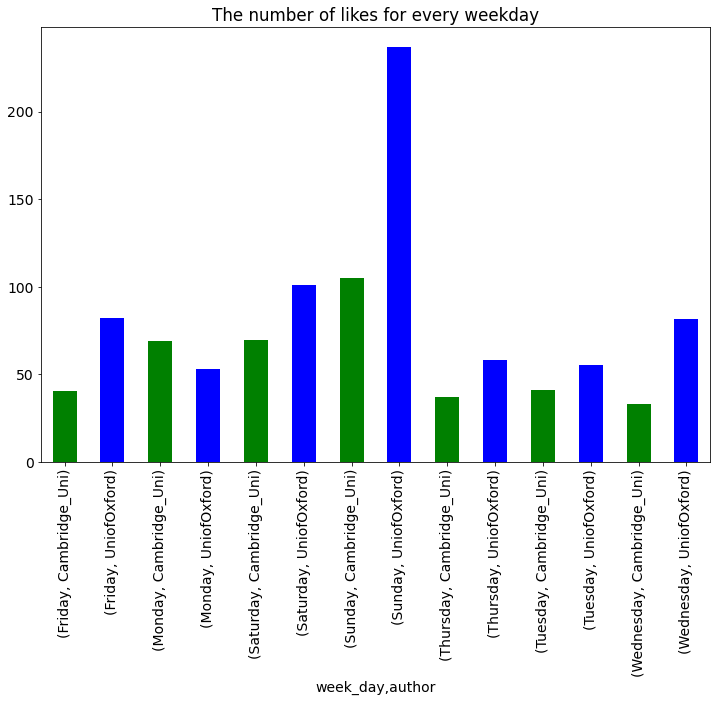

In [282]:
s = (final_tweets.groupby(['week_day','author'])['favorite_count'].sum()) / (final_tweets.groupby(['week_day','author'])['id'].count())
s.plot(title ='The number of likes for every weekday', 
       figsize = (12,8), 
       color = ['green','blue'],
       kind ='bar')

In [283]:
final_tweets['date'] = pd.to_datetime(final_tweets['date'])
final_tweets.set_index('date', inplace=True)

In [284]:
final_tweets.drop('index', axis = "columns", inplace = True)
final_tweets

,author,id,text,retweet_count,favorite_count,language,media,time,week_day
date,,,,,,,,,
2022-11-04 18:20:16,UniofOxford,1588597008083947523,"b""'As we avoid air pollution, which kills abou...",3,16,en,0,18:20:16,Friday
2022-11-04 17:00:01,UniofOxford,1588576815492349952,b'The University of Oxford hosted Taoiseach @M...,10,33,en,0,17:00:01,Friday
2022-11-04 16:22:32,UniofOxford,1588567381705904128,b'@VickyMaths1729 @PhilipMaini @OxUniMaths A f...,3,23,en,0,16:22:32,Friday
2022-11-04 16:00:02,UniofOxford,1588561716849381376,b'Innovative technological advancements in can...,5,18,en,0,16:00:02,Friday
2022-11-04 16:00:01,UniofOxford,1588561716610142208,b'\xf0\x9f\x8e\xa7 | In the first episode of o...,18,42,en,0,16:00:01,Friday
...,...,...,...,...,...,...,...,...,...
2020-11-12 13:26:00,Cambridge_Uni,1326878917660184576,"b'""I want to understand the systems and struct...",4,55,en,0,13:26:00,Thursday
2020-11-12 11:33:00,Cambridge_Uni,1326850479498944514,b'RT @CC4AIM: We are delighted to announce the...,31,0,en,0,11:33:00,Thursday
2020-11-12 09:44:40,Cambridge_Uni,1326823216908791808,b'RT @mdvestergaard: Are some people actively ...,11,0,en,0,09:44:40,Thursday


**Finding the following for specified interval of Time:**


*   **Total Number of Tweets**
*   **Total Number of Likes**
*   **Total Number of Retweets**


Using IPython Widgets for this analysis. 

The ipywidgets package provides many common user interface controls for exploring code and data interactively. These controls can be assembled and customized to create complex graphical user interfaces. 

Using ipython datepicker widget for this analyses.

In [285]:
print('*'*80)
print("Please, choose date interval to see some statistical information about tweets. ")
def print_tweets_published(start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    stat_df = final_tweets.loc[(final_tweets.index >= start_date) & (final_tweets.index <= end_date)].copy()

    total_likes_uni_1 = stat_df.loc[stat_df['author'] == screen_name_uni_1, ['favorite_count']].sum()[0]
    total_retweet_uni_1 = stat_df.loc[stat_df['author'] == screen_name_uni_1, ['retweet_count']].sum()[0]
    num_tweets_uni_1 = stat_df.loc[stat_df['author'] == screen_name_uni_1].count()[0]
    authors = stat_df['author'].unique()

    #ut=authors[0]
    #lu=authors[1]

    total_likes_uni_2 = stat_df.loc[stat_df['author'] == screen_name_uni_2, ['favorite_count']].sum()[0]
    total_retweet_uni_2 = stat_df.loc[stat_df['author'] == screen_name_uni_2, ['retweet_count']].sum()[0]
    num_tweets_uni_2 = stat_df.loc[stat_df['author'] == screen_name_uni_2].count()[0]

    #authors = stat_df['author'].unique()

    print('*'*80)
    print(f'{screen_name_uni_1} published {num_tweets_uni_1} tweets between {start_date.date()} and {end_date.date()}.')
    print(f'These tweets have got {total_likes_uni_1} likes and retweeted by {total_retweet_uni_1} totally.')
    print('-' * 80)
    print(f'On the other hand, {screen_name_uni_2} published {num_tweets_uni_2} tweets during this time.')
    print(f'These tweets have got {total_likes_uni_2} likes and retweeted by {total_retweet_uni_2}.')
    print('*'*80)
    
_ = interact(print_tweets_published,
             start_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2023-01-01')))

********************************************************************************
Please, choose date interval to see some statistical information about tweets. 


interactive(children=(DatePicker(value=Timestamp('2020-01-01 00:00:00'), description='start_date'), DatePicker…

**Interactive plotting the cumulative of either Favorite count or retweet count upto a certain date:**

Using ipython dropdown and datepicker widegets for this analyses.

In [286]:
import cufflinks as cf
from plotly.offline import init_notebook_mode
import plotly.io as pio
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
def plot_up_to(column, date):
    date = pd.Timestamp(date)
    plot_df = final_tweets.loc[final_tweets.index <= date].copy()
    plot_df[column].cumsum().iplot(mode = 'markers+lines', 
                                   xTitle = 'date',
                                   yTitle = column, 
                                  title = f'Cumulative {column.title()} Until {date.date()}')
    pio.renderers.default = 'colab'
    
_ = interact(plot_up_to, column=widgets.Dropdown(options=('favorite_count','retweet_count')), 
             date = widgets.DatePicker(value = pd.to_datetime('2022-10-31')))

interactive(children=(Dropdown(description='column', options=('favorite_count', 'retweet_count'), value='favor…

###**4.2 What is the relationship between the number of likes of tweets and other variables?**

Dividing the day into 6 parts to analyse number of likes:

*   Early morning 5 ~ 8
*   Morning 8 ~ 11
*   Late morning 11 ~ 12
*   Early afternoon 13 ~ 15
*   Late afternoon 15 ~ 17
*   Early evening 17 ~ 19
*   Late evening 19 ~ 21
*   Night 21 ~ 4


In [287]:
daypart=[]
for i in final_tweets.time:
    if (i.hour) >= 5 and i.hour < 8:
        daypart.append('Early Morning')
    elif i.hour >= 8 and i.hour < 11:
        daypart.append('Morning')
    elif i.hour >= 11 and i.hour < 12:
        daypart.append('Late Morning')
    elif i.hour >= 12 and i.hour < 15:
        daypart.append('Early Afternoon')
    elif i.hour >= 15 and i.hour < 17:
        daypart.append('Late Afternoon')
    elif i.hour >= 17 and i.hour < 19:
        daypart.append('Early Evening')
    elif i.hour >= 19 and i.hour < 21:
        daypart.append('Late Evening')
    elif i.hour >= 21 or i.hour < 5:
        daypart.append('Night')
final_tweets['day_part']=daypart

In [288]:
final_tweets.head()

,author,id,text,retweet_count,favorite_count,language,media,time,week_day,day_part
date,,,,,,,,,,
2022-11-04 18:20:16,UniofOxford,1588597008083947523,"b""'As we avoid air pollution, which kills abou...",3,16,en,0,18:20:16,Friday,Early Evening
2022-11-04 17:00:01,UniofOxford,1588576815492349952,b'The University of Oxford hosted Taoiseach @M...,10,33,en,0,17:00:01,Friday,Early Evening
2022-11-04 16:22:32,UniofOxford,1588567381705904128,b'@VickyMaths1729 @PhilipMaini @OxUniMaths A f...,3,23,en,0,16:22:32,Friday,Late Afternoon
2022-11-04 16:00:02,UniofOxford,1588561716849381376,b'Innovative technological advancements in can...,5,18,en,0,16:00:02,Friday,Late Afternoon
2022-11-04 16:00:01,UniofOxford,1588561716610142208,b'\xf0\x9f\x8e\xa7 | In the first episode of o...,18,42,en,0,16:00:01,Friday,Late Afternoon


Learning sentiment values of tweets by using textblob.

In [289]:
from textblob import TextBlob
l=[]
for tweet in final_tweets.text:
    analysis = TextBlob(tweet)
    if analysis.sentiment[0]>0:
        l.append('Positive')
    elif analysis.sentiment[0]==0:
        l.append('Neutral')
    else:
        l.append('Negative')
final_tweets['sentiment']=l

In [290]:
final_tweets.head()

,author,id,text,retweet_count,favorite_count,language,media,time,week_day,day_part,sentiment
date,,,,,,,,,,,
2022-11-04 18:20:16,UniofOxford,1588597008083947523,"b""'As we avoid air pollution, which kills abou...",3,16,en,0,18:20:16,Friday,Early Evening,Neutral
2022-11-04 17:00:01,UniofOxford,1588576815492349952,b'The University of Oxford hosted Taoiseach @M...,10,33,en,0,17:00:01,Friday,Early Evening,Neutral
2022-11-04 16:22:32,UniofOxford,1588567381705904128,b'@VickyMaths1729 @PhilipMaini @OxUniMaths A f...,3,23,en,0,16:22:32,Friday,Late Afternoon,Neutral
2022-11-04 16:00:02,UniofOxford,1588561716849381376,b'Innovative technological advancements in can...,5,18,en,0,16:00:02,Friday,Late Afternoon,Positive
2022-11-04 16:00:01,UniofOxford,1588561716610142208,b'\xf0\x9f\x8e\xa7 | In the first episode of o...,18,42,en,0,16:00:01,Friday,Late Afternoon,Positive


To use sentiment attribute in regression analysis, we convert it into indicator variables using the panda's method 'get_dummies' which assigns numerical values to different categories of sentiment.

In [291]:
dummy_variable_1 = pd.get_dummies(final_tweets["sentiment"])
dummy_variable_1.head()

,Negative,Neutral,Positive
date,,,
2022-11-04 18:20:16,0,1,0
2022-11-04 17:00:01,0,1,0
2022-11-04 16:22:32,0,1,0
2022-11-04 16:00:02,0,0,1
2022-11-04 16:00:01,0,0,1


In [292]:
# merge data frame "df" and "dummy_variable_1" 
final_tweets = pd.concat([final_tweets, dummy_variable_1], axis=1)
final_tweets.drop("sentiment", axis = 1, inplace=True)
final_tweets.head()

,author,id,text,retweet_count,favorite_count,language,media,time,week_day,day_part,Negative,Neutral,Positive
date,,,,,,,,,,,,,
2022-11-04 18:20:16,UniofOxford,1588597008083947523,"b""'As we avoid air pollution, which kills abou...",3,16,en,0,18:20:16,Friday,Early Evening,0,1,0
2022-11-04 17:00:01,UniofOxford,1588576815492349952,b'The University of Oxford hosted Taoiseach @M...,10,33,en,0,17:00:01,Friday,Early Evening,0,1,0
2022-11-04 16:22:32,UniofOxford,1588567381705904128,b'@VickyMaths1729 @PhilipMaini @OxUniMaths A f...,3,23,en,0,16:22:32,Friday,Late Afternoon,0,1,0
2022-11-04 16:00:02,UniofOxford,1588561716849381376,b'Innovative technological advancements in can...,5,18,en,0,16:00:02,Friday,Late Afternoon,0,0,1
2022-11-04 16:00:01,UniofOxford,1588561716610142208,b'\xf0\x9f\x8e\xa7 | In the first episode of o...,18,42,en,0,16:00:01,Friday,Late Afternoon,0,0,1


In [293]:
uni_1 = final_tweets.loc[final_tweets['author'] == screen_name_uni_1]
uni_2 = final_tweets.loc[final_tweets['author'] == screen_name_uni_2]


In [294]:
uni_1['day_part'].value_counts()

Morning            1069
Early Afternoon     891
Late Afternoon      525
Late Morning        312
Early Evening       293
Late Evening         90
Early Morning        46
Night                24
Name: day_part, dtype: int64

In [295]:
uni_2['day_part'].value_counts()

Morning            972
Early Afternoon    760
Late Afternoon     587
Late Morning       361
Early Evening      290
Early Morning      180
Late Evening        62
Night               37
Name: day_part, dtype: int64

In [296]:
uni_1_day_part_count = uni_1['day_part'].value_counts().to_frame()
uni_2_day_part_count = uni_2['day_part'].value_counts().to_frame()

# renaming index
uni_1_day_part_count.index.name = 'names'
uni_2_day_part_count.index.name = 'names'

In [297]:
uni_1_df_group_one = uni_1[['day_part','week_day','favorite_count']]
uni_2_df_group_one = uni_2[['day_part','week_day','favorite_count']]

**Tweets during which part of day got maximum likes:**

In [336]:
print("University Name:", screen_name_uni_1)
uni_1_df_group_one = uni_1_df_group_one.groupby(['day_part'],as_index=False).mean()
uni_1_df_group_one.sort_values('favorite_count',ascending=False)

University Name: UniofOxford


,day_part,favorite_count
4,Late Evening,310.544444
1,Early Evening,166.153584
2,Early Morning,115.869565
0,Early Afternoon,66.618406
5,Late Morning,62.836538
6,Morning,61.788587
3,Late Afternoon,61.739048
7,Night,47.250000


In [338]:
print("University Name:", screen_name_uni_2)
uni_2_df_group_one = uni_2_df_group_one.groupby(['day_part'],as_index=False).mean()
uni_2_df_group_one.sort_values('favorite_count',ascending=False)

University Name: Cambridge_Uni


,day_part,favorite_count
1,Early Evening,101.555172
3,Late Afternoon,47.260647
6,Morning,44.554527
0,Early Afternoon,40.288158
7,Night,38.810811
5,Late Morning,36.493075
4,Late Evening,34.209677
2,Early Morning,27.683333


**Pivot Table to Analyse Fovorite Count based on Part of Day and Negative Sentiment:**

The grouped data is much easier to visualize when it is made into a pivot table. A pivot table is like an Excel spreadsheet, with one variable along the column and another along the row.

In [300]:
def get_grouped_pivot(uni, sentiment):
  # grouping results for uni
  uni_df_gptest = uni[['day_part',sentiment,'favorite_count']]
  uni_grouped_test1 = uni_df_gptest.groupby(['day_part', sentiment],as_index=False).mean()
  uni_grouped_test1.sort_values('favorite_count',ascending=False)

  uni_grouped_pivot = uni_grouped_test1.pivot(index='day_part',columns=sentiment)
  return uni_grouped_pivot

In [339]:
print("University Name:", screen_name_uni_1)
get_grouped_pivot(uni_1, 'Negative')

University Name: UniofOxford


favorite_count            
Negative                     0           1
day_part                                  
Early Afternoon      70.027534   37.010870
Early Evening       171.033457  111.458333
Early Morning       118.340909   61.500000
Late Afternoon       62.965164   45.567568
Late Evening        321.686047   71.000000
Late Morning         61.238596   79.703704
Morning              64.350515   36.686869
Night                49.304348    0.000000

In [340]:
print("University Name:", screen_name_uni_2)
get_grouped_pivot(uni_2, 'Negative')

University Name: Cambridge_Uni


favorite_count           
Negative                     0          1
day_part                                 
Early Afternoon      39.491525  51.134615
Early Evening       104.578182  46.133333
Early Morning        28.857143  11.250000
Late Afternoon       47.346296  46.276596
Late Evening         31.620690  71.750000
Late Morning         35.631902  44.514286
Morning              43.074444  63.055556
Night                38.805556  39.000000

In [303]:
def plot_heatmap(uni_grouped_pivot):
  fig, ax = plt.subplots()
  im = ax.pcolor(uni_grouped_pivot, cmap='RdBu')

  #label names
  row_labels = uni_grouped_pivot.columns.levels[1]
  col_labels = uni_grouped_pivot.index

  #move ticks and labels to the center
  ax.set_xticks(np.arange(uni_grouped_pivot.shape[1]) + 0.5, minor=False)
  ax.set_yticks(np.arange(uni_grouped_pivot.shape[0]) + 0.5, minor=False)

  #insert labels
  ax.set_xticklabels(row_labels, minor=False)
  ax.set_yticklabels(col_labels, minor=False)

  #rotate label if too long
  plt.xticks(rotation=90)

  fig.colorbar(im)
  plt.show()

**Visualizing how the favorite_count is related to 'day part' and 'Negative' sentiment:**

University Name: UniofOxford


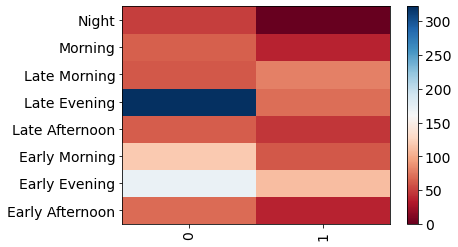

In [347]:
print("University Name:", screen_name_uni_1)
plot_heatmap(get_grouped_pivot(uni_1, 'Negative'))

University Name: Cambridge_Uni


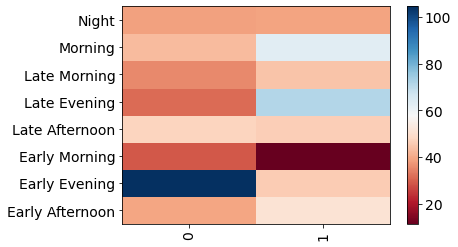

In [344]:
print("University Name:", screen_name_uni_2)
plot_heatmap(get_grouped_pivot(uni_2, 'Negative'))

# 5. Data Analysis - Beneficial to Student

###**5.1 Which word and hashtag were used most in shared tweets?** 

Step 1: Tokenizing the text, that is, remove everything that isn't a word (whitespace, punctuation, etc.)

In [306]:
for i in range(0,len(final_tweets.text)):
    final_tweets.text[i]=final_tweets.text[i][1:]

In [307]:
tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
final_tweets['text'].apply(tokenizer.tokenize)


date
2022-11-04 18:20:16    [As, we, avoid, air, pollution, which, kills, ...
2022-11-04 17:00:01    [The, University, of, Oxford, hosted, Taoiseac...
2022-11-04 16:22:32    [VickyMaths1729, PhilipMaini, OxUniMaths, A, f...
2022-11-04 16:00:02    [Innovative, technological, advancements, in, ...
2022-11-04 16:00:01    [xf0, x9f, x8e, xa7, In, the, first, episode, ...
                                             ...                        
2020-11-12 13:26:00    [I, want, to, understand, the, systems, and, s...
2020-11-12 11:33:00    [RT, CC4AIM, We, are, delighted, to, announce,...
2020-11-12 09:44:40    [RT, mdvestergaard, Are, some, people, activel...
2020-11-11 16:46:05    [What, are, the, elements, that, make, a, Camb...
2020-11-11 14:58:01    [RT, MRC_BSU, We, have, published, new, estima...
Name: text, Length: 6499, dtype: object

Step 2: Split the text into a list of words

In [308]:
import re
tokens = []
for i in final_tweets['text']:
  li = str(i).split(' ')
  for j in li:
    j.encode('utf-8').decode('utf-8')
    j = re.sub('\\\\(.{3})', '', j)
    j.encode('utf-8').decode('utf-8')
    j.replace('\'', '')
    tokens.append(j)


Step 3: Convert all words to lowercase to avoid repetition 

In [309]:
# A new list to hold the lowercased words
words = []

# Looping through the tokens and make them lower case
for word in tokens:
    words.append(word.lower())

# Printing out the first 8 words / tokens 
print(words[:8])

['"\'as', 'we', 'avoid', 'air', 'pollution,', 'which', 'kills', 'about']


Step 4: It is common practice to remove words that appear a lot in the English language such as 'the', 'of' and 'a' because they're not so interesting. Such words are known as stop words. The package nltk includes a good list of stop words in English that is being used.

In [310]:
nltk.download('stopwords')
sw = nltk.corpus.stopwords.words('english')
sw_with_colon = []
for i in sw:
  i = "\'" + i
  sw_with_colon.append(i)

# Printing out the first eight stop words
print(sw[:8])
print(sw)
print(sw_with_colon[:8])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves']
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'suc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Step 5: Customised a list of stop words that we don't want to be included in our analyses such as university names.

In [354]:
newStopWords = ['http','new','via','https','-', '_','&amp;','','x80','xa6','\"rt','\'rt','rt','co','xe2','amp','x9f','xf0','xc3','cambridge','oxford', 'university', '|', '\"']
sw.extend(newStopWords)

Step 6: Creating a final list of words

In [355]:
words_ns = []

# Appending to words_ns all words that are in words but not in sw
for word in words:
    if word not in sw and word not in sw_with_colon:
        words_ns.append(word)

# Printing the first 5 words_ns to check that stop words are gone
print(words_ns[:5])

['"\'as', 'avoid', 'air', 'pollution,', 'kills']


**Word Frequency Distribution**

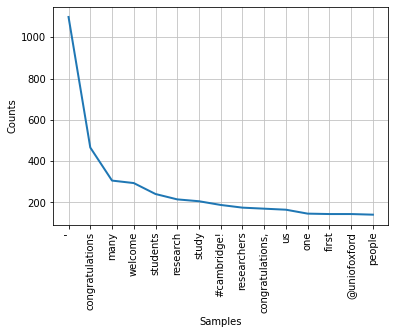

In [356]:
%matplotlib inline

# Creating the word frequency distribution
freqdist = nltk.FreqDist(words_ns)

# Plotting the word frequency distribution
freqdist.plot(15)


###**5.2 Which hashtags do universities use mostly?**

In [314]:
def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet) 

In [315]:
final_tweets['hashtags'] = final_tweets.text.apply(find_hashtags)

In [316]:
final_tweets.head()

,author,id,text,retweet_count,favorite_count,language,media,time,week_day,day_part,Negative,Neutral,Positive,hashtags
date,,,,,,,,,,,,,,
2022-11-04 18:20:16,UniofOxford,1588597008083947523,"""'As we avoid air pollution, which kills about...",3,16,en,0,18:20:16,Friday,Early Evening,0,1,0,[]
2022-11-04 17:00:01,UniofOxford,1588576815492349952,'The University of Oxford hosted Taoiseach @Mi...,10,33,en,0,17:00:01,Friday,Early Evening,0,1,0,[]
2022-11-04 16:22:32,UniofOxford,1588567381705904128,'@VickyMaths1729 @PhilipMaini @OxUniMaths A fe...,3,23,en,0,16:22:32,Friday,Late Afternoon,0,1,0,[]
2022-11-04 16:00:02,UniofOxford,1588561716849381376,'Innovative technological advancements in canc...,5,18,en,0,16:00:02,Friday,Late Afternoon,0,0,1,[]
2022-11-04 16:00:01,UniofOxford,1588561716610142208,'\xf0\x9f\x8e\xa7 | In the first episode of ou...,18,42,en,0,16:00:01,Friday,Late Afternoon,0,0,1,[]


In [317]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = final_tweets.loc[
                       final_tweets.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]
hashtags_list_df.head()

,hashtags
date,
2022-11-03 16:57:34,"[#COP27, #NextIndustrialRevolution]"
2022-11-02 16:02:56,[#COP27]
2022-11-01 12:45:40,[#ApplyingToOxford]
2022-11-01 09:43:35,[#WorldVeganDay]
2022-10-31 12:12:49,[#Halloween2022]


In [318]:
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])
flattened_hashtags_df.head()

,hashtag
0,#COP27
1,#NextIndustrialRevolution
2,#COP27
3,#ApplyingToOxford
4,#WorldVeganDay


In [319]:
# number of unique hashtags
print(flattened_hashtags_df['hashtag'].unique().size)

# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
print(popular_hashtags)                                   

884
               hashtag  counts
0           #Cambridge     396
1             #COVID19     147
2    #GoingToCambridge      70
3       #GoingToOxford      70
4               #COP26      35
..                 ...     ...
879          #Chanukah       1
880        #REFresults       1
881        #Rainforest       1
882     #RamadanKareem       1
883              #yoga       1

[884 rows x 2 columns]


**Top 25 Hashtags:**

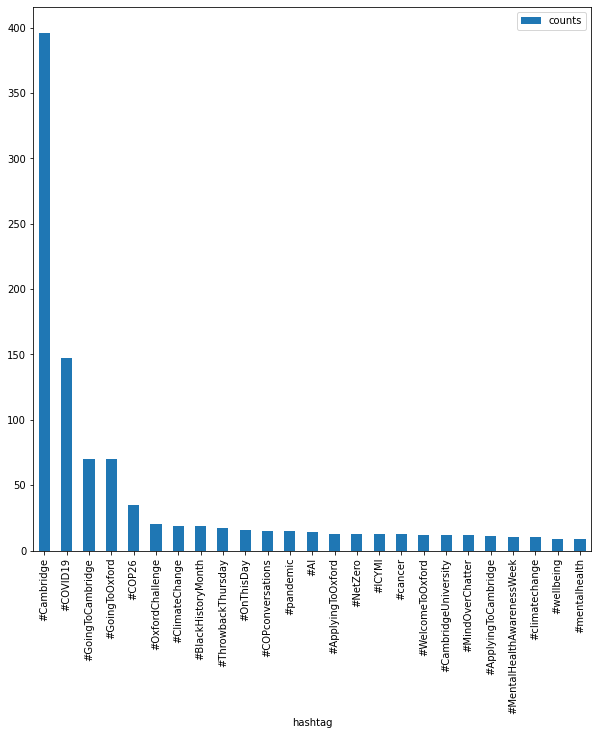

In [320]:
popular_hashtags[:25].plot(kind='bar', x='hashtag', y='counts',figsize=(10,10))

**Frequency of Hashtags with a certain Number of Appearances:**

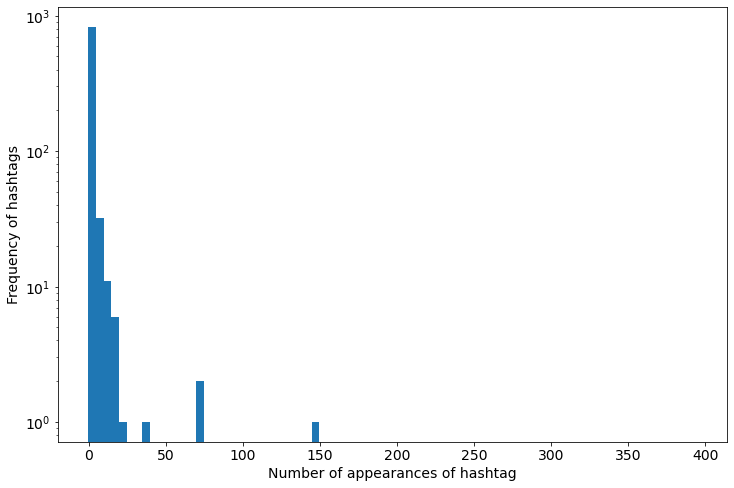

In [321]:
import numpy as np
import matplotlib.pyplot as plt
# number of times each hashtag appears
counts = flattened_hashtags_df.groupby(['hashtag']).size()\
                              .reset_index(name='counts')\
                              .counts

# define bins for histogram                              
my_bins = np.arange(0,counts.max()+2, 5)-0.5

# plot histogram of tweet counts
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 14})
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('Number of appearances of hashtag')
plt.ylabel('Frequency of hashtags')
plt.yscale('log', nonposy='clip')
plt.show()

In [322]:
# take hashtags which appear at least this amount of times
min_appearance = 10
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

In [323]:
# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]
popular_hashtags_list_df.head()

,hashtags,popular_hashtags
date,,
2022-11-01 12:45:40,[#ApplyingToOxford],[#ApplyingToOxford]
2022-10-28 08:53:42,[#OxfordChallenge],[#OxfordChallenge]
2022-10-27 09:10:01,"[#OxfordChallenge, #ApplyingToOxford]","[#OxfordChallenge, #ApplyingToOxford]"
2022-10-26 11:14:29,[#BlackHistoryMonth],[#BlackHistoryMonth]
2022-10-25 09:07:45,[#BlackHistoryMonth],[#BlackHistoryMonth]


In [324]:
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

**Correlation between the different hashtags appearing in the same tweets:**

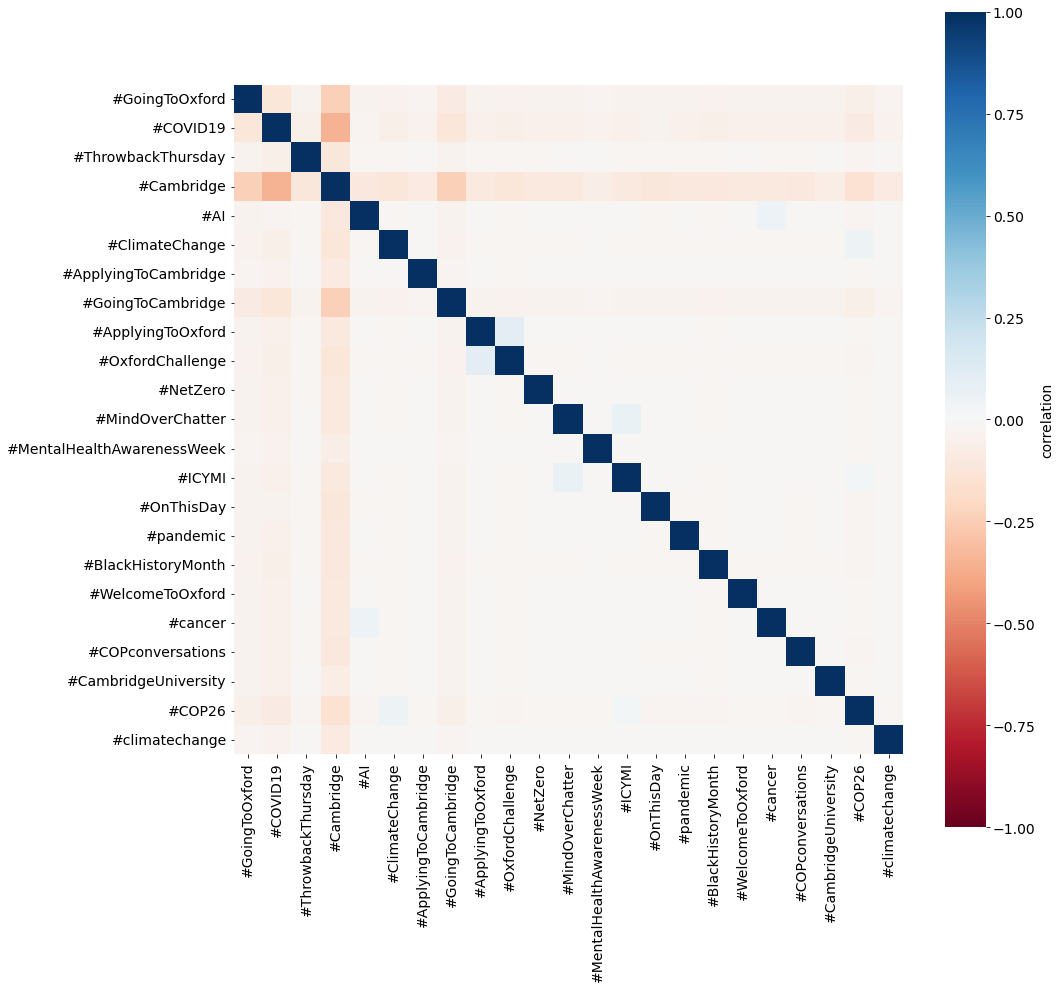

In [325]:
import seaborn as sns
# calculate the correlation matrix
correlations = hashtag_matrix.corr()
# plot the correlation matrix
plt.figure(figsize=(15,15))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

###**5.3 Which university is more active in summer holidays?**

In [326]:
final_tweets.head()

,author,id,text,retweet_count,favorite_count,language,media,time,week_day,day_part,Negative,Neutral,Positive,hashtags
date,,,,,,,,,,,,,,
2022-11-04 18:20:16,UniofOxford,1588597008083947523,"""'As we avoid air pollution, which kills about...",3,16,en,0,18:20:16,Friday,Early Evening,0,1,0,[]
2022-11-04 17:00:01,UniofOxford,1588576815492349952,'The University of Oxford hosted Taoiseach @Mi...,10,33,en,0,17:00:01,Friday,Early Evening,0,1,0,[]
2022-11-04 16:22:32,UniofOxford,1588567381705904128,'@VickyMaths1729 @PhilipMaini @OxUniMaths A fe...,3,23,en,0,16:22:32,Friday,Late Afternoon,0,1,0,[]
2022-11-04 16:00:02,UniofOxford,1588561716849381376,'Innovative technological advancements in canc...,5,18,en,0,16:00:02,Friday,Late Afternoon,0,0,1,[]
2022-11-04 16:00:01,UniofOxford,1588561716610142208,'\xf0\x9f\x8e\xa7 | In the first episode of ou...,18,42,en,0,16:00:01,Friday,Late Afternoon,0,0,1,[]


In [327]:
print('*'*80)
print("Please, choose date interval for summer holidays to see some statistical information about tweets. ")
def print_tweets_published(start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    stat_df = final_tweets.loc[(final_tweets.index >= start_date) & (final_tweets.index <= end_date)].copy()

    total_likes_uni_1 = stat_df.loc[stat_df['author'] == screen_name_uni_1, ['favorite_count']].sum()[0]
    total_retweet_uni_1 = stat_df.loc[stat_df['author'] == screen_name_uni_1, ['retweet_count']].sum()[0]
    num_tweets_uni_1 = stat_df.loc[stat_df['author'] == screen_name_uni_1].count()[0]
    authors = stat_df['author'].unique()


    total_likes_uni_2 = stat_df.loc[stat_df['author'] == screen_name_uni_2, ['favorite_count']].sum()[0]
    total_retweet_uni_2 = stat_df.loc[stat_df['author'] == screen_name_uni_2, ['retweet_count']].sum()[0]
    num_tweets_uni_2 = stat_df.loc[stat_df['author'] == screen_name_uni_2].count()[0]

    #authors = stat_df['author'].unique()

    print('*'*80)
    print(f'{screen_name_uni_1} published {num_tweets_uni_1} tweets between {start_date.date()} and {end_date.date()}.')
    print(f'These tweets have got {total_likes_uni_1} likes and retweeted by {total_retweet_uni_1} totally.')
    print('-' * 80)
    print(f'On the other hand, {screen_name_uni_2} published {num_tweets_uni_2} tweets during this time.')
    print(f'These tweets have got {total_likes_uni_2} likes and retweeted by {total_retweet_uni_2}.')
    print('*'*80)
    
_ = interact(print_tweets_published,
             start_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2023-01-01')))

********************************************************************************
Please, choose date interval for summer holidays to see some statistical information about tweets. 


interactive(children=(DatePicker(value=Timestamp('2020-01-01 00:00:00'), description='start_date'), DatePicker…

/usr/local/lib/python3.7/dist-packages/traitlets/traitlets.py:588: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

